# Training a Binary Classifier with Active Learning

The notebook provides you with a complete code example that uses active learning to classify points in a plane into two classes.

## Creating a Dataset with Two Groups of Data Points

Create a dataset with two groups of data ...

In [46]:
import numpy as np

gr0 = np.random.normal(loc=(-2, 0), scale=(1, 1), size=(100, 2))
gr1 = np.random.normal(loc=(2, 0), scale=(1, 1), size=(100, 2))

x = np.vstack((gr0, gr1))
y = np.hstack((np.zeros(len(gr0)), np.ones(len(gr1))))

... and plot it.

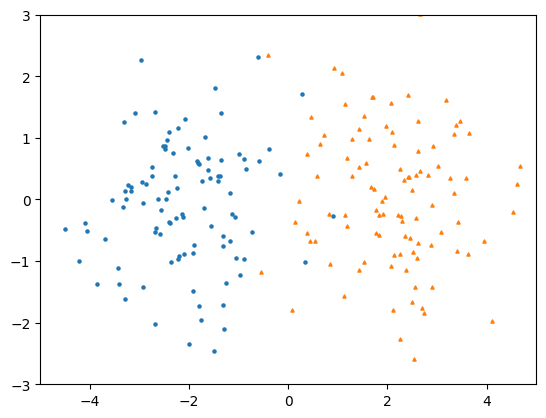

In [47]:
import matplotlib.pyplot as plt

plt.scatter(gr0[:, 0], gr0[:, 1], marker="o", s=5, c="C0")
plt.scatter(gr1[:, 0], gr1[:, 1], marker="^", s=5, c="C1")
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.savefig("fig_12_01.pdf", bbox_inches='tight')  ### plt.show()

## Classifying the Data Points with a Logistic Regression

Implement a function to train and test the model with logistic regression ...

In [48]:
from sklearn.linear_model import LogisticRegression

def train_model(x_train, y_train, x_test, y_test):
    """Find optimal decision boundary using a logistic regression."""
    model = LogisticRegression()
    model.fit(x_train, y_train)
    accuracy = model.score(x_test, y_test)
    return model, accuracy

... train and test the model on the entire dataset ...

In [49]:
model, full_accuracy = train_model(x, y, x, y)

... and print the accuracy on the whole dataset.

In [50]:
print(full_accuracy)

0.975


## Implementing the Active Learning Process

Implement a function to perform the active learning for binary classification.

In [51]:
def train_active_learning(x, y, budget, query):
    """Train binary classifier with active learning."""
    annotated_idxs = [np.random.choice(np.where(y == i)[0]) for i in [0, 1]]
    unannotated_idxs = np.setdiff1d(np.arange(x.shape[0]), annotated_idxs)

    accuracy_history = []
    for _ in range(budget):
        annotated_x, annotations = x[annotated_idxs], y[annotated_idxs]
        unannotated_x = x[unannotated_idxs]

        model, accuracy = train_model(annotated_x, annotations, x, y)
        accuracy_history.append(accuracy)
        
        idx_to_annotate = query(model, unannotated_x)
        annotated_idxs = np.append(annotated_idxs, 
                                   unannotated_idxs[idx_to_annotate])
        unannotated_idxs = np.delete(unannotated_idxs, idx_to_annotate)

    return accuracy_history, model, annotated_idxs

### Random Sampling

Implement a function to select a data point at random ...

In [52]:
def query_random(model, unannotated_x):
    """Select data point to annotate randomly."""
    return np.random.randint(len(unannotated_x))

... perform active learning with a random query strategy ...

In [53]:
accuracy_history_random, model_random, annotated_idxs_random = \
    train_active_learning(x, y, budget=25, query=query_random)

... implement the function to plot the model, the annotated data, and its decision boundary ...

In [54]:
def plot_model(model, gr0, gr1, annotated_x, annotations, figname):  ### def plot_model(model, gr0, gr1, annotated_x, annotations):
    """Plot model decision boundary and annotated data."""
    plt.scatter(gr0[:, 0], gr0[:, 1], marker="o", s=0.5, c="C0")
    plt.scatter(gr1[:, 0], gr1[:, 1], marker="^", s=0.5, c="C1")

    plt.scatter(annotated_x[~annotations, 0], annotated_x[~annotations, 1], 
                marker="o", s=100, c="C0", label="Selected Group 1")
    plt.scatter(annotated_x[annotations, 0], annotated_x[annotations, 1], 
                marker="^", s=100, c="C1", label="Selected Group 2")

    beta_1, beta_2 = model.coef_[0]
    intercept = model.intercept_
    boundary_x = np.linspace(-5, 5, 100)
    boundary_y = (- intercept - beta_1 * boundary_x) / beta_2
    plt.plot(boundary_x, boundary_y, c="black", label="Decision Boundary")

    plt.xlim(-5, 5)
    plt.ylim(-3, 3)
    plt.legend()
    plt.savefig(figname, bbox_inches='tight')  ### plt.show()

... and plot it.

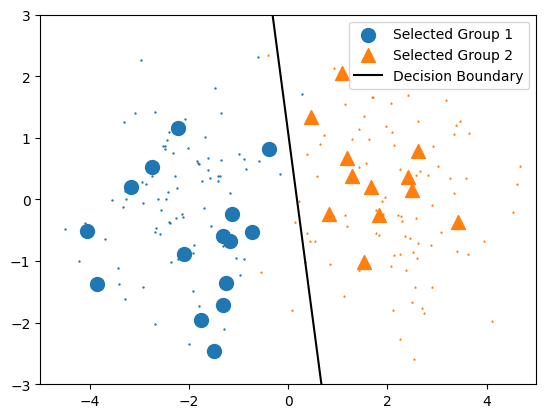

In [55]:
plot_model(model_random, gr0, gr1, 
           annotated_x=x[annotated_idxs_random], 
           annotations=y[annotated_idxs_random].astype(bool), figname="fig_12_02.pdf")  ###

### Uncertainty Sampling

Implement the function to select data with uncertainty sampling ...

In [56]:
def query_uncertainty(model, unannotated_x):
    """Select data point to annotate randomly with uncertainty sampling."""    
    probabilities = model.predict_proba(unannotated_x)
    return np.argmin(np.max(probabilities, axis=1))

... perform active learning ...

In [57]:
accuracy_history_uncertainty, model_uncertainty, annotated_idxs_uncertainty = \
    train_active_learning(x, y, budget=25, query=query_uncertainty)

... and plot the results.

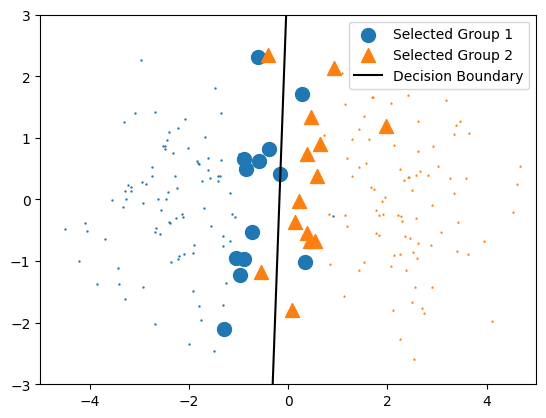

In [58]:
plot_model(model_uncertainty, gr0, gr1, 
           annotated_x=x[annotated_idxs_uncertainty], 
           annotations=y[annotated_idxs_uncertainty].astype(bool), figname="fig_12_03.pdf")  ###

## Comparing Random and Uncertainty Sampling Strategies

Calculate the average accuracy as a function of annotations over multiple trials ...

In [59]:
trials = 50

accuracy_histories_random, accuracy_histories_uncertainty = [], []
for i in range(trials):
    accuracy_history_random, *_ = \
        train_active_learning(x, y, budget=25, query=query_random)
    accuracy_histories_random.append(accuracy_history_random)
    
    accuracy_history_uncertainty, *_ = \
        train_active_learning(x, y, budget=25, query=query_uncertainty)
    accuracy_histories_uncertainty.append(accuracy_history_uncertainty)

... and plot the average accuracy as a function of annotations over multiple trials.

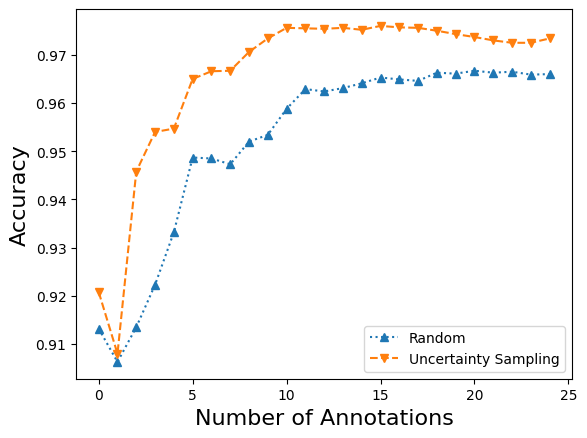

In [60]:
plt.plot(np.mean(accuracy_histories_random, axis=0), "^:", label="Random")
plt.plot(np.mean(accuracy_histories_uncertainty, axis=0), "v--", 
         label="Uncertainty Sampling")
plt.xlabel("Number of Annotations", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend()
plt.savefig("fig_12_04 .pdf", bbox_inches='tight')  ### plt.show()